# Sex Associated Contigs


In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression
from sklearn import metrics
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)

MICROBE_FILE = BLOOD_MICROBIOME_DIR + 'data/kraken_align/microbe_filtered_species.tsv'
FIG_DIR = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association'
TAX_IDS_TO_GREP_FILE = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association/tax_ids_to_grep.txt'
TAX_NAMES_TO_GREP_FILE = BLOOD_MICROBIOME_DIR + 'results/y_chrom_association/tax_names_to_grep.txt'

df_microbe = pd.read_table(MICROBE_FILE, index_col=0).transpose()

In [2]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)

In [3]:
y_associated_contigs = f_regress_results[f_regress_results.exog_value=='sex_numeric_2.0'].sort_values(
    'coeff_abs', ascending=False)
y_associated_contigs = y_associated_contigs[y_associated_contigs.coeff<0][['name']].drop_duplicates().name.values
y_associated_contigs


x_associated_contigs = f_regress_results[f_regress_results.exog_value=='sex_numeric_2.0'].sort_values(
    'coeff_abs', ascending=False)
x_associated_contigs = x_associated_contigs[x_associated_contigs.coeff>0][['name']].drop_duplicates().name.values

In [4]:
taxonomies = pd.read_csv('/home/groups/dpwall/briannac/blood_microbiome/data/kraken_align/taxonomies.tsv', sep='\t', header=None)
taxonomies.columns = ['frac', 'n', '2', 'tax_level', 'tax_id', 'tax_name']
taxonomies.tax_name = [''.join(n[np.where(np.array(list(n))!=' ')[0][0]:]) for n in taxonomies.tax_name]

In [5]:
y_taxonomies = taxonomies[[n in y_associated_contigs for n in taxonomies.tax_name]]
y_taxonomies = y_taxonomies[y_taxonomies.tax_id!=9606]

In [21]:
with open(TAX_IDS_TO_GREP_FILE, 'w') as f:
    for i in [r"kraken:taxid%s$" % str(t)  for t in y_taxonomies.tax_id]:
        f.write(i + '\n')
with open(TAX_NAMES_TO_GREP_FILE, 'w') as f:
    for i in [r"(taxid %s)" % str(t)  for t in y_taxonomies.tax_id]:
        f.write(i + '\n')
        
##kraken:tax_id\|1560339$
#kraken:tax_id\|28901$

In [39]:
kraken_classes = pd.read_table('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/y_chrom_association/02C10540.kraken_classes.tsv', header=None)

In [49]:
kraken_classes.columns = ['sample', 'read_id', 'tax_id', 'seq', 'read_id_dup', 'tax_name', 'kmer_length', 'kmer_classes']

In [51]:
kraken_classes.drop(['read_id_dup', 'kmer_length'], inplace=True, axis=1)

In [134]:
kraken_classes['kmers'] = [[s[i:(i+35)] for i in range(117)] for s in kraken_classes.seq]
kraken_classes['kmer_classes_list'] = kraken_classes.apply(KrakenToKmers, axis=1)

In [185]:
bam_mappings.loc['02C10540']

status                              Passed_QC_analysis_ready
participant_id                                     AU1005201
family                                                AU1005
AGRE Blood                                            HI2393
NIMH Blood                                          02C10540
                                              ...           
dbsnp_overlap                                            NaN
concordance_with_genotyping_chip                         NaN
cryptic_relatedness_check                                NaN
family_based_average_coverage                            NaN
familial_relationship_check                              NaN
Name: 02C10540, Length: 73, dtype: object

In [184]:
kraken_classes.groupby(['seq', 'sample']).count()[['read_id']].sort_values('read_id', ascending=False)

,,read_id
seq,sample,
ATAATATATATATTATGTCTATGTTATATATAGTATAAAACAACATATAATAATATATAATTGTATATATAAAATGCGACATATAATATATATTATATTTTATAACATATGTAATATATATTATATATTATATATAATACGTTGTATGTAT,02C10540,84
AAAATGCGACATATAATATATATTATATTTTATAACATATGTAATATATATTATATATTATATATAATACGTTGTATGTATAATACCTATATTAAATATATATTATATGACTATGTTATTAATTACATGTCACATGTGTTATATATTATAT,02C10540,71
ATATAATAATATATAATTGTATATATAAAATGCGACATATAATATATATTATATTTTATAACATATGTAATATATATTATATATTATATATAATACGTTGTATGTATAATACCTATATTAAATATATATTATATGACTATGTTATTAATTA,02C10540,71
ATATTCTATGTAAAATATATAATATATAACACATGTGACATGTAATTAATAACATAGTCATATAATATATATTTAATATAGGTATTATACATACAACGTATTATATATAATATATAATATATATTACATATGTTATAAAATATAATATATA,02C10540,70
GACATATAATATATATTATATTTTATAACATATGTAATATATATTATATATTATATATAATACGTTGTATGTATAATACCTATATTAAATATATATTATATGACTATGTTATTAATTACATGTCACATGTGTTATATATTATATATTTTAC,02C10540,70
...,...,...
CGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTGTTCATTTTTTTTTTATGTTTTAATTTTTTCTTTGTTTTTTTTATTTTCATTTTTTATTTTTTTTTATTATAGATTATATTTTGTTTTTATTTTTATATAATTTATGTTTTTTT,02C10540,1
CGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTATTTTTTGTTTTGTTTTTTTTTTTTTTTTGTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTTTTTTTTTGTTTTTTTTTTTTTTTTTTTTTTT,02C10540,1
CGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTTTTTTGGTTTTTTTGTTGGGGTGGGGTCGTGCTTTGTTGCCCCGCCTGTGTTGTGTGGCGGGTGTCCGTCTTCCCGCCCCCC,02C10540,1


In [166]:
kmers = kraken_classes[['sample', 'tax_id', 'kmer_classes_list']].groupby(['sample']).aggregate(lambda x:Counter([i for j in list(x) for i in j]).most_common())

In [173]:
kmers.kmer_classes_list[0][0]

('ATTTTATAACATATGTAATATATATTATATATTAT', 10816)

In [125]:
def KrakenToKmers(row):
    kraken_format_out = row['kmer_classes']
    desired_tax_id  = str(row['tax_id'])
    seq  = row['seq']
    
    tax_ids_n_seqs = [(i.split(':')[0],int(i.split(':')[1])) for i in  (kraken_format_out+ ' ').split(' ') if i!='']
    i = 0
    a = []
    for tax_id, n_seq in tax_ids_n_seqs:
        if tax_id == desired_tax_id:
            a = a + [seq[(i+s):(i+s+35)]for s in range(n_seq)]
        i = i + n_seq
    return a

kraken_classes['kmer_classes_list'] = kraken_classes.apply(KrakenToKmers, axis=1)

In [131]:
kraken['kmer_classes_list'] = kraken_classes.apply(KrakenToKmers, axis=1)

In [132]:
test

0       [TTTTTTTTTTATTTTTTTTTTATTTTTTTTTTTTA, TTTTTTTT...
1       [ACCGAATGGAGTGGAATGGAATAAACACCAGGGGA, CCGAATGG...
2       [CCATCCAACCATCCATCCATCCATCCATCCATCCA, CATCCAAC...
3       [AAAAGAAAAAAAAAATTTTTTTTTTTTTTTACTTA, AAAGAAAA...
4       [GACAGCCAGCCAGCCAAGCCAGCCAAGCCAGCCAA, ACAGCCAG...
                              ...                        
9995    [TTTTTTTTTGAAATTTTTTTTTATATATGAATATA, TTTTTTTT...
9996    [TGAGAAGGGTGGGGGGTGGGTGGGGGGGGGGGGGG, GAGAAGGG...
9997    [TATATAATATATAATATATATTACATATGTTATAA, ATATAATA...
9998    [TTTTTTTATTATTTTTATTTTTTTTATTTGTTTTA, TTTTTTAT...
9999    [AATATTTTTTTTTAATAAATATATAATTTAAAAAA, ATATTTTT...
Length: 10000, dtype: object

In [103]:
i = 0
a = []
for tax_id, n_seq in tax_ids_n_seqs:
    if tax_id == desired_tax_id:
        a = a + [seq[(i+s):(i+s+35)]for s in range(n_seq)]
    i = i + n_seq
return a
            
            
        

65
66
68
75
77
78
81
117


In [102]:
len(a[-1])

35

In [96]:
seq[65:100]

'CTTTTTTTTTTTTATTTTTTTTTTATTTTTTTTTT'

In [93]:
tax_ids_n_seqs

[(0, 65),
 (1241833, 1),
 (2, 2),
 (1653831, 7),
 (2, 2),
 (253, 1),
 (2, 3),
 (0, 36)]

In [52]:
for i in kraken_classes.iterrows():
    break

In [57]:
i[1].sample

<bound method NDFrame.sample of sample                                                   02C10540
read_id                   E00166:140:HF2FTCCXX:1:1101:10125:56265
tax_id                                                    1653831
seq             CGTGTTTTTTTTTTAAAACCCCCACCACAATGTCTCCTTTTCGGTT...
tax_name                  Blattabacterium cuenoti (taxid 1653831)
kmer_classes      0:65 1241833:1 2:2 1653831:7 2:2 253:1 2:3 0:36
Name: 0, dtype: object>

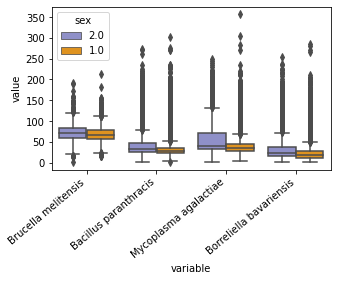

In [4]:
df_microbe['sex']=bam_mappings.loc[df_microbe.index].sex_numeric
df_melt = df_microbe[list(x_associated_contigs[:10]) + ['sex']].melt(id_vars='sex')
df_melt.value = df_melt.value+1
f, ax = plt.subplots(figsize=(5,3))
sns.boxplot(data=df_melt, x='variable', y='value', hue='sex', dodge=True)
#plt.xticks(rotation = 45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')

plt.show()

#df_microbe['sex']=bam_mappings.loc[df_microbe.index].sex_numeric

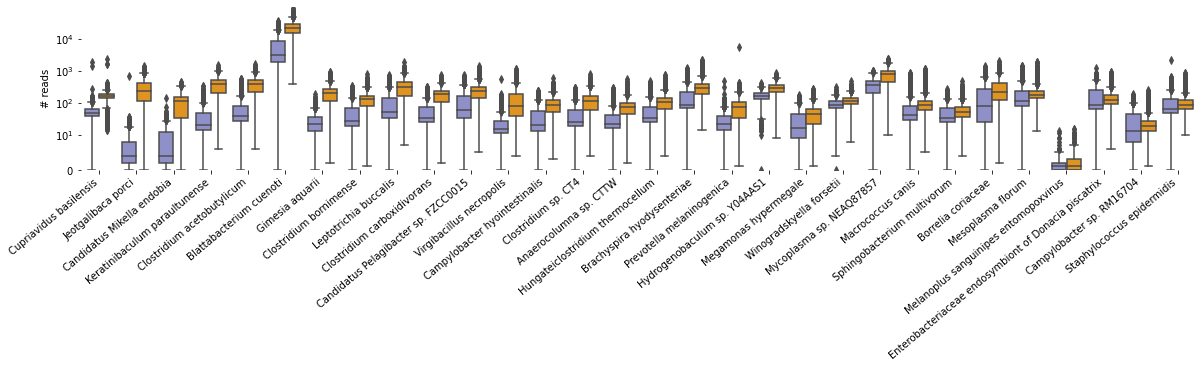

In [5]:
df_microbe['sex']=bam_mappings.loc[df_microbe.index].sex_numeric
df_melt = df_microbe[list(y_associated_contigs[:30]) + ['sex']].melt(id_vars='sex')
#df_melt.value = np.log10(df_melt.value+1)
f, ax = plt.subplots(figsize=(20,3))
sns.boxplot(data=df_melt, x='variable', y='value', hue='sex', dodge=True)
#plt.xticks(rotation = 45)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.yscale('symlog', linthresh=10)
plt.ylim(0,)
plt.xlabel('')
plt.ylabel('# reads')
plt.box(False)
plt.legend().remove()
#plt.savefig('%s/male_vs_female_abundances.svg' % FIG_DIR, 
#            transparent=True, bbox_inches='tight')
#plt.savefig('%s/male_vs_female_abundances.png' % FIG_DIR, 
#            transparent=True, bbox_inches='tight', dpi=300)
plt.show()
#plt.xlabel#
#df_microbe['sex']=bam_mappings.loc[df_microbe.index].sex_numeric

In [8]:
#y_associated_contigs

In [10]:
#df_microbe.drop(['sex', 'father'], axis=1, inplace=True)
participant_to_sample_id = {i:j for i,j in zip(bam_mappings.participant_id, bam_mappings.index) if j in df_microbe.index}
df_microbe_child_for_father = df_microbe[bam_mappings.loc[df_microbe.index].relationship=='sibling']
df_microbe_child_for_father = df_microbe_child_for_father[[f in participant_to_sample_id for f in bam_mappings.loc[df_microbe_child_for_father.index].FatherID]]
df_microbe_father = df_microbe.loc[[participant_to_sample_id[f]  for f in bam_mappings.loc[df_microbe_child_for_father.index].FatherID]]#

df_microbe_child_for_mother = df_microbe[bam_mappings.loc[df_microbe.index].relationship=='sibling']
df_microbe_child_for_mother = df_microbe_child_for_mother[[f in participant_to_sample_id for f in bam_mappings.loc[df_microbe_child_for_mother.index].MotherID]]
df_microbe_mother = df_microbe.loc[[participant_to_sample_id[f]  for f in bam_mappings.loc[df_microbe_child_for_mother.index].MotherID]]#

In [11]:
father_son_child = df_microbe_child_for_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0'][list(y_associated_contigs)]
father_son_parent = df_microbe_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0'][list(y_associated_contigs)]
father_son_child.index = list(range(len(father_son_child)))
father_son_parent.index = list(range(len(father_son_parent)))
father_son_corrs = [metrics.r2_score(father_son_child[c], father_son_parent[c]) for c in father_son_child.columns]

father_daughter_child = df_microbe_child_for_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='2.0'][list(y_associated_contigs)]
father_daughter_parent = df_microbe_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='2.0'][list(y_associated_contigs)]
father_daughter_child.index = list(range(len(father_daughter_child)))
father_daughter_parent.index = list(range(len(father_daughter_parent)))
father_daughter_corrs = [metrics.r2_score(father_daughter_child[c], father_daughter_parent[c]) for c in father_daughter_child.columns]

mother_son_child = df_microbe_child_for_mother[bam_mappings.loc[df_microbe_child_for_mother.index].sex_numeric.values=='1.0'][list(y_associated_contigs)]
mother_son_parent = df_microbe_mother[bam_mappings.loc[df_microbe_child_for_mother.index].sex_numeric.values=='1.0'][list(y_associated_contigs)]
mother_son_child.index = list(range(len(mother_son_child)))
mother_son_parent.index = list(range(len(mother_son_parent)))
mother_son_corrs = [metrics.r2_score(mother_son_child[c], mother_son_parent[c]) for c in mother_son_child.columns]

mother_daughter_child = df_microbe_child_for_mother[bam_mappings.loc[df_microbe_child_for_mother.index].sex_numeric.values=='2.0'][list(y_associated_contigs)]
mother_daughter_parent = df_microbe_mother[bam_mappings.loc[df_microbe_child_for_mother.index].sex_numeric.values=='2.0'][list(y_associated_contigs)]
mother_daughter_child.index = list(range(len(mother_daughter_child)))
mother_daughter_parent.index = list(range(len(mother_daughter_parent)))
mother_daughter_corrs = [metrics.r2_score(mother_daughter_child[c], mother_daughter_parent[c]) for c in mother_daughter_child.columns]


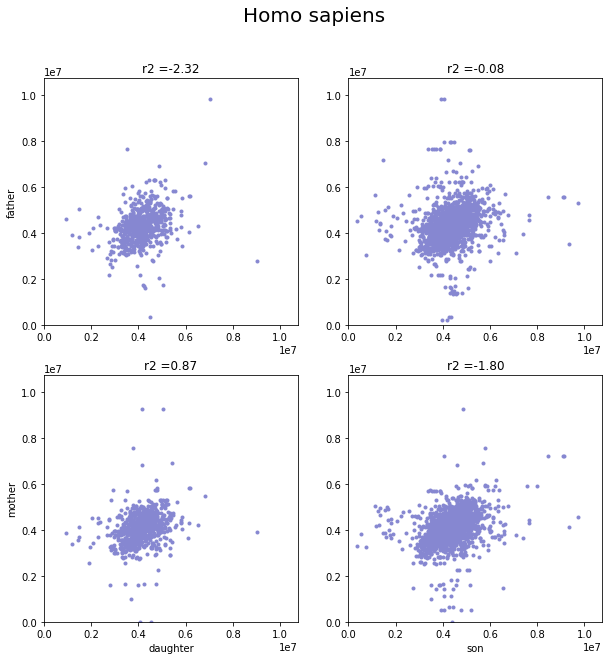

In [12]:
for i in range(1):
    val = 'Homo sapiens'
    #val=y_associated_contigs[i]
    f,ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
    ax[0,0].plot(father_daughter_child[val], father_daughter_parent[val], '.')
    ax[0,0].set_title('r2 =%.2f' % father_daughter_corrs[i])
    ax[0,0].set_xlim(0,2*np.percentile(df_microbe[val], 95))
    ax[0,0].set_ylim(0,2*np.percentile(df_microbe[val], 95))
    ax[0,1].plot(father_son_child[val], father_son_parent[val], '.')
    ax[0,1].set_title('r2 =%.2f' % father_son_corrs[i])
    ax[0,1].set_xlim(0,2*np.percentile(df_microbe[val], 95))
    ax[0,1].set_ylim(0,2*np.percentile(df_microbe[val], 95))
    ax[1,0].plot(mother_daughter_child[val], mother_daughter_parent[val], '.')
    ax[1,0].set_title('r2 =%.2f' % mother_daughter_corrs[i])
    ax[1,0].set_xlim(0,2*np.percentile(df_microbe[val], 95))
    ax[1,0].set_ylim(0,2*np.percentile(df_microbe[val], 95))
    ax[1,1].plot(mother_son_child[val], mother_son_parent[val], '.')
    ax[1,1].set_title('r2 =%.2f' % mother_son_corrs[i])
    ax[1,1].set_xlim(0,2*np.percentile(df_microbe[val], 95))
    ax[1,1].set_ylim(0,2*np.percentile(df_microbe[val], 95))
    ax[1,1].set_xlabel('son')
    ax[1,0].set_xlabel('daughter')
    ax[0,0].set_ylabel('father')
    ax[1,0].set_ylabel('mother')
    plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
    plt.rc('figure', titlesize=20)    # fontsize of the x and y labels
    plt.suptitle(val)
    #plt.savefig('%s/parent_child_corrs_%s.png' % (FIG_DIR, val.replace(" ", '_')), 
    #            transparent=True, bbox_inches='tight', dpi=300)
    #plt.savefig('%s/parent_child_corrs_%s.svg' % (FIG_DIR, val.replace(" ", '_')), 
    #            transparent=True, bbox_inches='tight')
    plt.show()

Virgibacillus necropolis


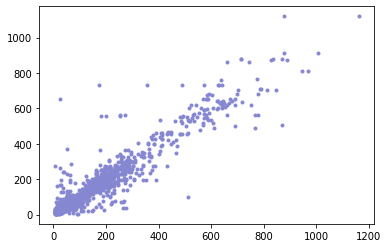

In [191]:
val = pd.DataFrame(father_son_corrs).sort_values(0)[::-1].index[0]
plt.plot(father_son_child[val], father_son_parent[val], '.')
print(val)

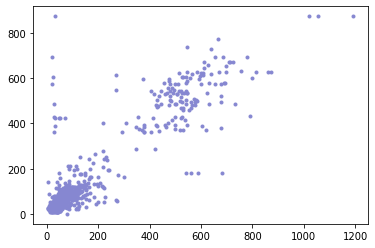

In [190]:
val = pd.DataFrame(mother_son_corrs).sort_values(0)[::-1].index[0]
plt.plot(mother_son_child[val], mother_son_parent[val], '.')

/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/briannac/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 72.,  47.,  21.,  70., 147., 137., 132., 111., 248., 518.]),
 array([-0.01235347,  0.08296695,  0.17828736,  0.27360778,  0.3689282 ,
         0.46424861,  0.55956903,  0.65488944,  0.75020986,  0.84553028,
         0.94085069]),
 <BarContainer object of 10 artists>)

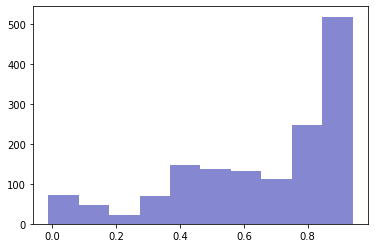

In [87]:
plt.hist(mother_son_corrs)

In [78]:
a = df_microbe_child_for_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0'].corrwith(
                                   df_microbe_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0'], axis=0)

KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n            ...\n            2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312],\n           dtype='int64', length=2313)] are in the [index]"

In [75]:
df_microbe_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0']

,Buchnera aphidicola,Sorangium cellulosum,Simonsiella muelleri,Cyclobacterium marinum,Isosphaera pallida,Borreliella burgdorferi,Borrelia hermsii,Borrelia coriaceae,Spirochaeta thermophila,Treponema denticola,...,Escherichia virus St1,Escherichia virus G4,Choristoneura murinana nucleopolyhedrovirus,Orpheovirus IHUMI-LCC2,Esparto virus,Pandoravirus macleodensis,Pandoravirus neocaledonia,Mythimna unipuncta granulovirus B,Staphylococcus virus Andhra,Murmansk microtuspox virus
MH0143008,55455,880,95,72,109,249,140,462,70,160,...,12,83,5,7,3,0,3,6,93,1
MH0143008,55455,880,95,72,109,249,140,462,70,160,...,12,83,5,7,3,0,3,6,93,1
MH0138051,59285,766,113,75,114,232,121,207,61,190,...,41,263,1,6,1,2,2,7,43,1
MH0138051,59285,766,113,75,114,232,121,207,61,190,...,41,263,1,6,1,2,2,7,43,1
MH0138043,93078,951,170,124,74,317,212,334,54,222,...,37,317,7,9,3,0,5,3,192,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10955,35150,1377,52,47,93,179,160,279,114,123,...,46,214,6,9,3,2,1,6,105,3
02C10946,15241,689,23,14,81,119,59,459,137,75,...,72,334,2,2,4,2,1,3,123,2
02C10858,51194,701,84,44,112,258,122,551,52,151,...,13,142,1,2,1,1,2,1,53,2
02C10858,51194,701,84,44,112,258,122,551,52,151,...,13,142,1,2,1,1,2,1,53,2


In [52]:
df_microbe_child_for_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0']

,Buchnera aphidicola,Sorangium cellulosum,Simonsiella muelleri,Cyclobacterium marinum,Isosphaera pallida,Borreliella burgdorferi,Borrelia hermsii,Borrelia coriaceae,Spirochaeta thermophila,Treponema denticola,...,Choristoneura murinana nucleopolyhedrovirus,Orpheovirus IHUMI-LCC2,Esparto virus,Pandoravirus macleodensis,Pandoravirus neocaledonia,Mythimna unipuncta granulovirus B,Staphylococcus virus Andhra,Murmansk microtuspox virus,sex,father
MH0143018,64386,775,123,91,82,222,148,271,62,186,...,4,8,0,3,3,8,75,8,1.0,MH0143008
MH0143013,66407,843,114,77,97,245,181,769,66,174,...,2,7,10,4,2,1,72,3,1.0,MH0143008
MH0138054,73696,875,142,91,105,322,176,495,60,260,...,4,8,3,3,3,13,164,2,1.0,MH0138051
MH0138050,83906,766,203,124,68,322,212,496,57,244,...,2,11,6,3,3,6,8,3,1.0,MH0138051
MH0138041,77785,896,130,86,95,305,177,479,50,175,...,5,3,1,4,5,10,114,6,1.0,MH0138043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10954,35360,927,60,41,76,251,164,292,103,132,...,2,4,2,2,0,2,81,7,1.0,02C10955
02C10949,2753,264,3,18,23,68,28,392,56,21,...,4,5,4,2,0,4,105,0,1.0,02C10946
02C10859,64680,768,108,93,87,285,164,329,51,187,...,4,10,2,4,1,5,43,3,1.0,02C10858
02C10857,67686,622,126,108,78,236,160,359,38,180,...,2,7,0,0,6,3,52,5,1.0,02C10858


In [50]:
df_microbe_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0']

,Buchnera aphidicola,Sorangium cellulosum,Simonsiella muelleri,Cyclobacterium marinum,Isosphaera pallida,Borreliella burgdorferi,Borrelia hermsii,Borrelia coriaceae,Spirochaeta thermophila,Treponema denticola,...,Choristoneura murinana nucleopolyhedrovirus,Orpheovirus IHUMI-LCC2,Esparto virus,Pandoravirus macleodensis,Pandoravirus neocaledonia,Mythimna unipuncta granulovirus B,Staphylococcus virus Andhra,Murmansk microtuspox virus,sex,father
MH0143008,55455,880,95,72,109,249,140,462,70,160,...,5,7,3,0,3,6,93,1,1.0,0
MH0143008,55455,880,95,72,109,249,140,462,70,160,...,5,7,3,0,3,6,93,1,1.0,0
MH0138051,59285,766,113,75,114,232,121,207,61,190,...,1,6,1,2,2,7,43,1,1.0,0
MH0138051,59285,766,113,75,114,232,121,207,61,190,...,1,6,1,2,2,7,43,1,1.0,0
MH0138043,93078,951,170,124,74,317,212,334,54,222,...,7,9,3,0,5,3,192,3,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10955,35150,1377,52,47,93,179,160,279,114,123,...,6,9,3,2,1,6,105,3,1.0,0
02C10946,15241,689,23,14,81,119,59,459,137,75,...,2,2,4,2,1,3,123,2,1.0,0
02C10858,51194,701,84,44,112,258,122,551,52,151,...,1,2,1,1,2,1,53,2,1.0,0
02C10858,51194,701,84,44,112,258,122,551,52,151,...,1,2,1,1,2,1,53,2,1.0,0


In [43]:
df_microbe_child_for_father[bam_mappings.loc[df_microbe_child_for_father.index].sex_numeric.values=='1.0']

,Buchnera aphidicola,Sorangium cellulosum,Simonsiella muelleri,Cyclobacterium marinum,Isosphaera pallida,Borreliella burgdorferi,Borrelia hermsii,Borrelia coriaceae,Spirochaeta thermophila,Treponema denticola,...,Choristoneura murinana nucleopolyhedrovirus,Orpheovirus IHUMI-LCC2,Esparto virus,Pandoravirus macleodensis,Pandoravirus neocaledonia,Mythimna unipuncta granulovirus B,Staphylococcus virus Andhra,Murmansk microtuspox virus,sex,father
MH0143018,64386,775,123,91,82,222,148,271,62,186,...,4,8,0,3,3,8,75,8,1.0,MH0143008
MH0143013,66407,843,114,77,97,245,181,769,66,174,...,2,7,10,4,2,1,72,3,1.0,MH0143008
MH0138054,73696,875,142,91,105,322,176,495,60,260,...,4,8,3,3,3,13,164,2,1.0,MH0138051
MH0138050,83906,766,203,124,68,322,212,496,57,244,...,2,11,6,3,3,6,8,3,1.0,MH0138051
MH0138041,77785,896,130,86,95,305,177,479,50,175,...,5,3,1,4,5,10,114,6,1.0,MH0138043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10954,35360,927,60,41,76,251,164,292,103,132,...,2,4,2,2,0,2,81,7,1.0,02C10955
02C10949,2753,264,3,18,23,68,28,392,56,21,...,4,5,4,2,0,4,105,0,1.0,02C10946
02C10859,64680,768,108,93,87,285,164,329,51,187,...,4,10,2,4,1,5,43,3,1.0,02C10858
02C10857,67686,622,126,108,78,236,160,359,38,180,...,2,7,0,0,6,3,52,5,1.0,02C10858


In [32]:
[participant_to_sample_id[f] for f in bam_mappings.loc[df_microbe_child_for_father.index].FatherID])

2338

In [33]:
participant_to_sample_id = {i:j for i,j in zip(bam_mappings.participant_id, bam_mappings.index) if j in df_microbe.index}

# Build table of fuso & mollicutes counts.

# Sex, batch, and cell type effects

***Hypothesis: this batch effect is due to higher concentrations of restriction enzymes / shearing chemicals, making it more likely the sequence gets chopped too small*** 

# Family Transmissibility

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


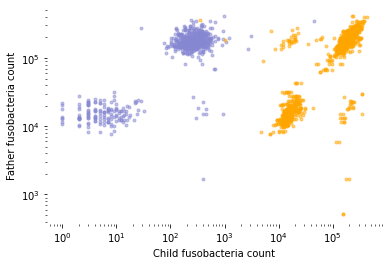

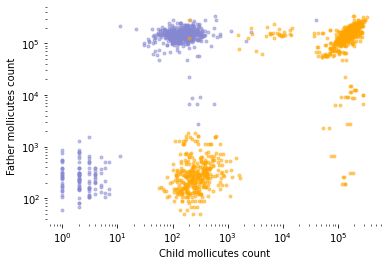

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


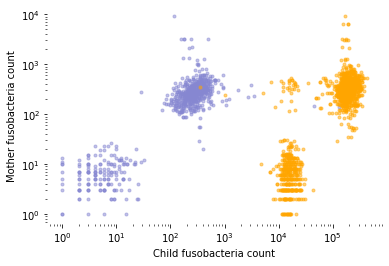

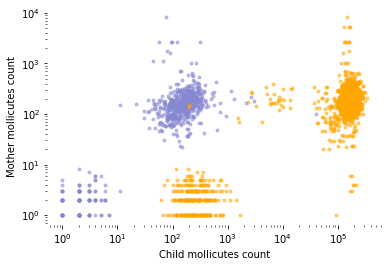

In [14]:
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>-1]

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(fathers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[kids.family.values]
kids['parent_fuso'] = fathers['fusobacterium'].values
kids['parent_mollicutes'] = fathers['mollicutes'].values

plt.plot(kids[kids.sex=='2.0'].fusobacterium.values, kids[kids.sex=='2.0'].parent_fuso.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].fusobacterium.values, kids[kids.sex=='1.0'].parent_fuso.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child fusobacteria count')
plt.ylabel('Father fusobacteria count')
plt.box(on=False)
plt.savefig('%s/fusobacteria_child_father.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

plt.plot(kids[kids.sex=='2.0'].mollicutes.values, kids[kids.sex=='2.0'].parent_mollicutes.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].mollicutes.values, kids[kids.sex=='1.0'].parent_mollicutes.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child mollicutes count')
plt.ylabel('Father mollicutes count')
plt.box(on=False)
plt.savefig('%s/mollicutes_child_father.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()


fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>-1]
mothers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='mother']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(mothers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(mothers_all.family, return_index=True)
mothers = mothers_all.iloc[idx]
mothers = mothers[[f in family_idx for f in mothers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
mothers.index=mothers.family
mothers = mothers.loc[kids.family.values]
kids['parent_fuso'] = mothers['fusobacterium'].values
kids['parent_mollicutes'] = mothers['mollicutes'].values

plt.plot(kids[kids.sex=='2.0'].fusobacterium.values, kids[kids.sex=='2.0'].parent_fuso.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].fusobacterium.values, kids[kids.sex=='1.0'].parent_fuso.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child fusobacteria count')
plt.ylabel('Mother fusobacteria count')
plt.box(on=False)
plt.savefig('%s/fusobacteria_child_mother.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()


plt.plot(kids[kids.sex=='2.0'].mollicutes.values, kids[kids.sex=='2.0'].parent_mollicutes.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].mollicutes.values, kids[kids.sex=='1.0'].parent_mollicutes.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child mollicutes count')
plt.ylabel('Mother mollicutes count')
plt.box(on=False)
plt.savefig('%s/mollicutes_child_mother.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()



In [15]:
mothers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='mother']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(mothers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(mothers_all.family, return_index=True)
mothers = mothers_all.iloc[idx]
mothers = mothers[[f in family_idx for f in mothers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
mothers.index=mothers.family
mothers = mothers.loc[kids.family.values]
kids['parent_fuso'] = mothers['fusobacterium'].values
kids['parent_mollicutes'] = mothers['mollicutes'].values

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


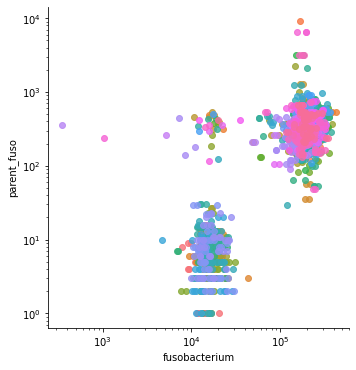

In [16]:
g=sns.lmplot(data=kids[kids.sex=='1.0'], x='fusobacterium', y='parent_fuso', hue='batch', fit_reg=False)
g._legend.remove()
plt.xscale('log')
plt.yscale('log')

# Which are correlated?

In [17]:
print('Father/son high cluster')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>10000]
fuso_mollicutes_count_high.fusobacterium = (fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = (fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('fusobacterium ~ parent_fuso + C(batch)', data=sons,  family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_fuso'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/son high cluster
0.0
0.0


/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [18]:
print('Father/son low cluster')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes<10000]
fuso_mollicutes_count_high.fusobacterium = (fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = (fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('fusobacterium ~ parent_fuso + C(batch)', data=sons,  family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_fuso'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/son low cluster
0.0
8.648006348590198e-26


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
print('Father/daughter')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>15]
fuso_mollicutes_count_high.fusobacterium = np.log10(fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = np.log10(fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='2.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/daughter
0.961219355077991
0.961219355077991


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
print('Mother/daughter')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>15]
fuso_mollicutes_count_high.fusobacterium = np.log10(fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = np.log10(fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])


#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Mother/daughter
0.7262293269084039
0.7262293269084039


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Correlated
- father/son mollicutes (in the high cluster) 
- father/son fusobacterium (in the high cluster)
- father /son fusobacterium (in the low cluster)

### Not correlated
- father/son mollicutes (in the low cluster)
- mother/* *
- father/daughter * 




# Correlation to Phenotype

In [160]:
sons = fuso_mollicutes_count[(fuso_mollicutes_count.relationship=='sibling') & 
                            (fuso_mollicutes_count.sex=='1.0')]
daughters = fuso_mollicutes_count[(fuso_mollicutes_count.relationship=='sibling') & 
                            (fuso_mollicutes_count.sex=='2.0')]

In [161]:
daughters
cont_female  = pd.crosstab(daughters['fusobacterium']>100, 
                            daughters['pheno'],  
                               margins = False)[['autism', 'nan']]

chi2, p, dof, ex = stats.chi2_contingency(cont_female)
print(cont_female)
print(p)
cont_male  = pd.crosstab(sons['fusobacterium']>100000, 
                            sons['pheno'],  
                               margins = False)[['autism', 'nan']]
chi2, p, dof, ex = stats.chi2_contingency(cont_male)
print(p)
print(cont_male)

pheno          autism  nan
fusobacterium             
False             126   61
True              291  172
0.3175121159794405
0.34330781794730836
pheno          autism  nan
fusobacterium             
False             345   47
True              953  156


**No correlation to phenotype.**

# Alignments

## Batch results
- 'Fusobacterium' contig aligns to: https://www.ncbi.nlm.nih.gov/nucleotide/AP023649.1?report=genbank&log$=nuclalign&blast_rank=1&RID=TPSYXJXC013
- No alignment for 'Mollicutes'

Both contigs are a little over 1kb.

In [ ]:
male_low = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_00009/02C11465/02C11465.final_alignment_table.csv')
female_low = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_00009/03C14334/03C14334.final_alignment_table.csv')
male_high = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_01019/08C74703/08C74703.final_alignment_table.csv')
female_high = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_01020/07C68441/07C68441.final_alignment_table.csv')


male_low


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


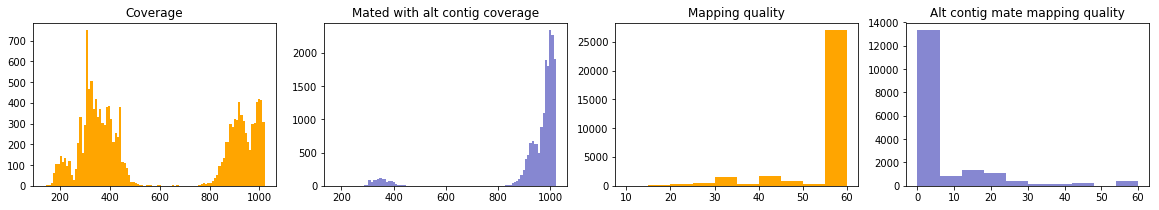

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 14502), ('chr13', 9010), ('chrUn_JTFH01001465v1_decoy', 1991), ('chrUn_JTFH01001981v1_decoy', 1406), ('chr22', 1329), ('chr21', 1230), ('chr22_KI270731v1_random', 491), ('chrUn_JTFH01001669v1_decoy', 419), ('chrUn_JTFH01001405v1_decoy', 398), ('chr22_KI270734v1_random', 349)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


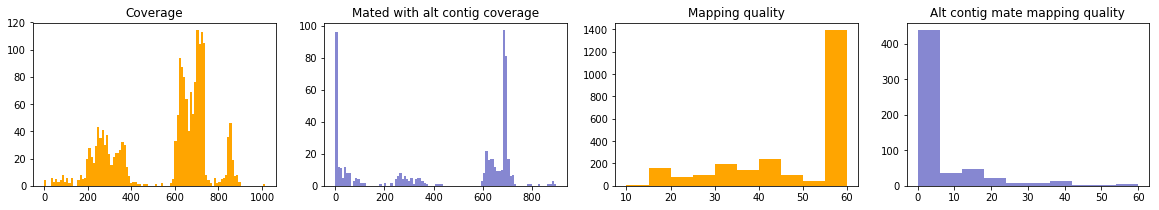

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 1860), ('chrUn_JTFH01001987v1_decoy', 105), ('chrUn_JTFH01001405v1_decoy', 83), ('chrUn_JTFH01001512v1_decoy', 75), ('chrUn_JTFH01001981v1_decoy', 55), ('chrUn_JTFH01000876v1_decoy', 54), ('chr21', 36), ('chrUn_JTFH01001506v1_decoy', 27), ('chrUn_JTFH01001553v1_decoy', 25), ('chrUn_JTFH01001669v1_decoy', 23)]
male_high


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


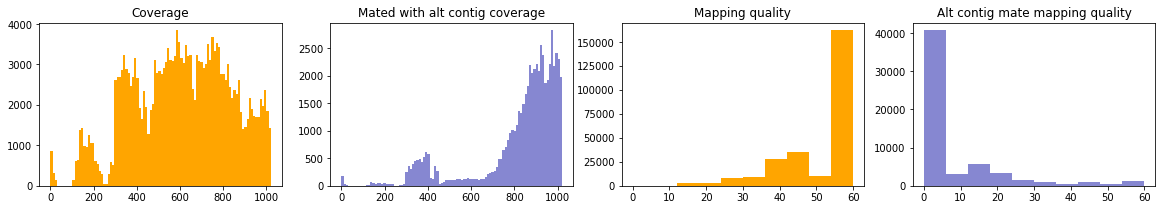

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 200756), ('chr13', 19875), ('chrUn_JTFH01001465v1_decoy', 6354), ('chr22', 4870), ('chrUn_JTFH01001680v1_decoy', 4014), ('chr21', 3578), ('chrUn_JTFH01001981v1_decoy', 2957), ('chr22_KI270731v1_random', 1797), ('chrUn_JTFH01001677v1_decoy', 1648), ('chrUn_JTFH01001669v1_decoy', 1549)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


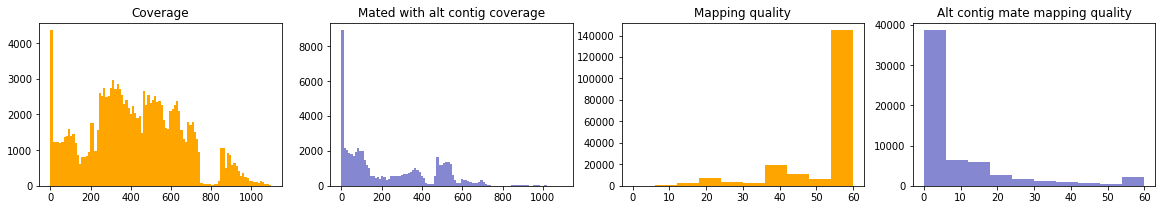

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 137894), ('chrUn_JTFH01001512v1_decoy', 14863), ('chrUn_JTFH01000876v1_decoy', 11357), ('chrUn_JTFH01001987v1_decoy', 4633), ('chr21', 4378), ('chr22', 3879), ('chrUn_JTFH01001669v1_decoy', 3168), ('chrUn_JTFH01001405v1_decoy', 2490), ('chr6', 1723), ('chr22_KI270734v1_random', 1587)]
female_low


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


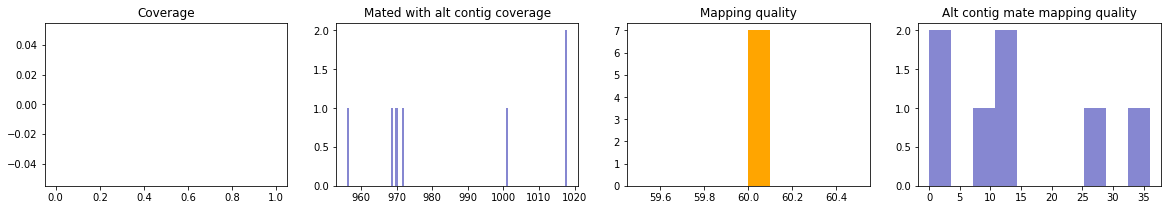

[('chrUn_JTFH01001465v1_decoy', 2), ('chrUn_JTFH01001405v1_decoy', 2), ('chr22', 1), ('chrUn_JTFH01001680v1_decoy', 1), ('chr13', 1)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


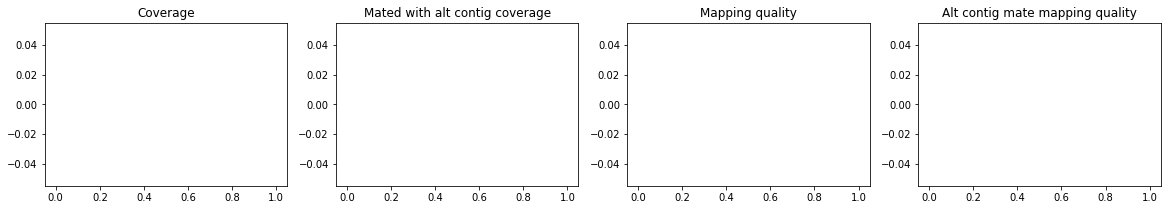

[]
female_high


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


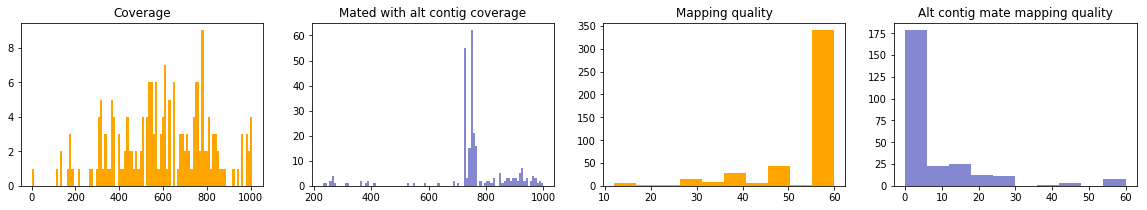

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 190), ('chr22', 56), ('chr13', 40), ('chrUn_JTFH01001987v1_decoy', 37), ('chrUn_JTFH01001981v1_decoy', 28), ('chr10', 16), ('chrUn_JTFH01001465v1_decoy', 10), ('chr2', 9), ('chr1', 6), ('chrUn_JTFH01001677v1_decoy', 6)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


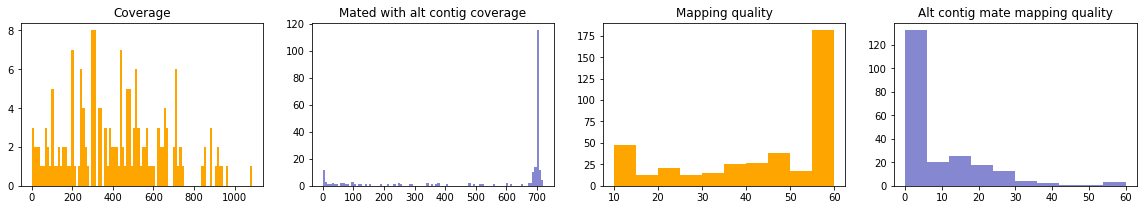

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 178), ('chrUn_JTFH01001987v1_decoy', 39), ('chr22', 23), ('chrUn_JTFH01001553v1_decoy', 15), ('chr6', 14), ('chrUn_JTFH01001512v1_decoy', 14), ('chrUn_JTFH01001981v1_decoy', 13), ('chrUn_JTFH01000876v1_decoy', 12), ('chr21', 10), ('chrUn_JTFH01001319v1_decoy', 10)]


In [182]:

fusobacterium_idx = 'BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|' 
mollicutes_idx = 'BACT_769|gi|223714005|gb|ACDT01000210.1|'

def AlignmentGraphs(table, idx):
    print('\n\n', idx)
    coverage = [
        int(i) for i in table[(table['R1_ref']==idx) & table.is_proper_pair].R1_start] + [
        int(i) for i in table[(table['R2_ref']==idx) & table.is_proper_pair].R2_start]
    improper_pair_coverage = [
        int(i) for i in table[(table['R1_ref']==idx) & (table['R2_ref']!=idx)].R1_start] + [
        int(i) for i in table[(table['R2_ref']==idx) &(table['R1_ref']!=idx)].R2_start]
    mapq = [
        int(i) for i in table[table['R1_ref']==idx].R1_MAPQ] + [
        int(i) for i in table[table['R2_ref']==idx].R2_MAPQ]
    pair_mapq = [
        int(i) for i in table[(table['R1_ref']==idx) & (table['R2_ref']!=idx)].R2_MAPQ if ~np.isnan(i)] + [
        int(i) for i in table[(table['R2_ref']==idx) & (table['R1_ref']!=idx)].R1_MAPQ if ~np.isnan(i)]
    pairs = list(
        table[table['R1_ref']==idx].R2_ref.values) +  list(
        table[table['R2_ref']==idx].R1_ref.values)

    f,ax = plt.subplots(1,4, figsize=(20,3))
    ax[0].hist(coverage, bins=100, color='orange')
    ax[0].set_title('Coverage')
    ax[1].hist(improper_pair_coverage, bins=100, color='#8687d1')
    ax[1].set_title('Mated with alt contig coverage')
    ax[2].hist(mapq, bins=10, color='orange')
    ax[2].set_title('Mapping quality')
    ax[3].hist(pair_mapq, bins=10, color='#8687d1')
    ax[3].set_title('Alt contig mate mapping quality')
    plt.show()
    print(Counter(pairs).most_common(10))

for title, example_table in zip(['male_low', 'male_high', 'female_low', 'female_high'], 
                                [male_low, male_high, female_low, female_high]):
    print(title)
    for idx in [fusobacterium_idx, mollicutes_idx]:
        AlignmentGraphs(example_table, idx)


## Reference Sequences

In [169]:
# Looking at sequences
bact_seqs = [r for r in SeqIO.parse('/scratch/groups/dpwall/personal/chloehe/unmapped_reads/ref_genome/combined.fa', 'fasta') if 
            ((r.id=='BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|') | (r.id=='BACT_769|gi|223714005|gb|ACDT01000210.1|'))]

In [37]:
count = Counter(np.concatenate([alignment['R1_ref'].values, alignment['R2_ref'].values]))

In [33]:
ids['BACT_769|gi|223714005|gb|ACDT01000210.1|']

'BACT_769|gi|223714005|gb|ACDT01000210.1| Mollicutes bacterium D7 cont1.210, whole genome shotgun sequence'

In [119]:
ids['BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|']

'BACT_577|gi|224473368|ref|NZ_ACDH01000101.1| Fusobacterium ulcerans ATCC 49185 NZ_ACDH01000101, whole genome shotgun sequence'